# Automation Notebook for Feature Preprocessing And Model Grid Search

## Setup

**Imports**

In [1]:
import numpy as np
import pandas as pd

import sklearn as skl
from sklearn import preprocessing as pp

from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

from run_vanilla_sim import run_vanilla_sim

# from keras.wrappers.scikit_learn import KerasClassifier #Deprecated
from scikeras.wrappers import KerasClassifier, KerasRegressor


import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib notebook

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


**Utility Functions**

In [14]:
def createNN(layer_params=[],compile_params=[[],{'loss':'mean_squared_error', 'optimizer':'adam', 'metrics':['mse']}],model=Sequential):
    """Construct an arbitrary Keras layered model
        layer_params and compile params must have form list(iterable(list,dict)), 
            ex: [[[layer1_args],{layer1_kwarg1:val,layer1_kwarg2:val}],
                [[layer2_args],{layer2_kwarg1:val,layer2_kwarg2:val}]]
            While this may seem cumbersome, it provides full flexibility in creating the model object
    """
    model=model()
    for i in range(len(layer_params)):
        args=layer_params[i][0]
#         print(args)
        kwargs=layer_params[i][1]
#         print(kwargs)
        model.add(Dense(*args,**kwargs))
    model.compile(*compile_params[0],**compile_params[1])
    return model

def bulk_layers(n,layer_params):
    """Construct appropriate input dicts for bulk of the same layer"""
    return [layer_params for i in range(n)]



def get_driver_layers(HL_scale,input_dim,activation='relu',base=64):
    """Construct layer_params for createNN() in accordance with the NN architecture we want for our controller
        Layer0: base # neurons, input dim set to match features
        Layer1-3: base*HL_scale neurons
        Layer4: 1 output, linear activation. Always used to produce the final angle for the controller
    """
    layers=[[[base], {'input_dim':input_dim, 'activation':activation}],
[[base*HL_scale], {'activation':activation}],
[[base*HL_scale], {'activation':activation}],
[[1], {'activation':'linear'}]]
    return layers

def simulate_model(model,worlds,scaler,batch_size,draw):
    """runs the simulator with a given model, along a set of worlds. returns the total number of succesful runs, along with a world by world Pass/Fail"""
    world_pf={}
    world_c_iters={}
    pf_sum=0
    for w in worlds:
        ctrl_iters,pas=run_vanilla_sim(model,scaler,batch_size,w,draw)
        world_pf[w]=pas
        world_c_iters[w]=ctrl_iters
        pf_sum+=pas
    avg_ctrl_iters=np.array(list(world_c_iters.values())).mean()
    return pf_sum,avg_ctrl_iters,world_pf,world_c_iters


#We ultimately opted for a grid search rather than a random search,but this func facilitates the latter
def get_random_model(layer_sizes,activations,depth,input_dim,output_dim,compile_params=[[],{'loss':'mean_squared_error', 'optimizer':'adam', 'metrics':['mse']}]):
    rng=np.random.default_rng()
    lyrs=rng.choice(layer_sizes,size=depth)
    activ=rng.choice(activations,size=depth+1)
    layers=[[[lyrs[0]],{'input_dim':input_dim,'activation':activ[0]}]] #create input layer
    for i in range(1,depth):
        layers.append([[lyrs[i]],{'activation':activ[i]}])
    layers.append([[1],{'activation':activ[-1]}]) #create output layer
    
    return layers



**Read in Training Data**

In [3]:
raw_data=pd.read_csv('ObsRecordUniformRandom_v6.csv')
# world_data=pd.read_csv('characteristics_by_world.csv')
lidar_list = ["Lidar"+str(x) for x in range(0,32)]
state_list = ["goalDist","goalAng","forceAng","World"]
partial_header = ["goalDist","goalAng","forceAng"]
headers = lidar_list + ["goalDist","goalAng","forceAng","world"]
raw_data.columns = headers
raw_data.head()

,Lidar0,Lidar1,Lidar2,Lidar3,Lidar4,Lidar5,Lidar6,Lidar7,Lidar8,Lidar9,...,Lidar26,Lidar27,Lidar28,Lidar29,Lidar30,Lidar31,goalDist,goalAng,forceAng,world
0,247.893806,247.840625,247.785500,248.054547,247.677382,247.370146,247.060256,247.197183,234.538793,246.955314,...,248.596971,248.002374,248.310385,247.962004,248.132722,247.893806,682.416781,0.182311,0.182311,0.0
1,247.646698,247.633177,247.626295,247.380814,246.908174,247.384328,247.134689,237.294400,246.757087,129.552642,...,215.566898,83.604179,70.480951,63.055482,58.020171,247.646698,475.189830,0.331269,-0.453922,0.0
2,148.342961,153.305580,162.476017,180.022935,214.542634,247.685564,247.539845,246.987629,247.268179,246.818484,...,248.545412,215.275962,180.599071,162.877860,153.507083,148.342961,970.661654,-0.003084,-0.003084,0.0
3,175.560950,247.497083,247.445961,247.732918,247.386986,247.121945,164.585376,182.441562,169.402827,174.680226,...,248.490721,247.832961,248.084057,247.688246,178.193886,175.560950,355.953772,0.373284,0.373284,0.0
4,133.370792,138.034908,145.039977,162.849097,157.983503,135.035633,121.976762,114.490006,114.146201,116.578104,...,248.546385,193.351458,163.408049,145.430242,138.231152,133.370792,1031.742639,0.300093,0.300093,0.0


In [4]:
raw_data.describe()

,Lidar0,Lidar1,Lidar2,Lidar3,Lidar4,Lidar5,Lidar6,Lidar7,Lidar8,Lidar9,...,Lidar26,Lidar27,Lidar28,Lidar29,Lidar30,Lidar31,goalDist,goalAng,forceAng,world
count,232132.000000,232132.000000,232132.000000,232132.000000,232132.000000,232132.000000,232132.000000,232132.000000,232132.000000,232132.000000,...,232132.000000,232132.000000,232132.000000,232132.000000,232132.000000,232132.000000,232132.000000,232132.000000,232132.000000,232132.000000
mean,151.109227,146.952400,144.263135,143.072438,143.421126,144.475820,147.440722,151.791101,152.714265,150.265446,...,147.535573,145.929835,145.328523,146.071173,148.263239,151.109227,745.212990,0.033957,-0.103430,149.548524
std,98.014879,98.053876,97.975028,97.865167,97.959615,98.073955,98.499028,99.302529,99.590426,99.559147,...,97.596355,97.431746,97.412363,97.554735,97.869937,98.014879,220.411135,0.374446,1.437986,86.607203
min,0.010831,0.010831,0.010831,0.010831,0.010831,0.010831,0.010831,0.010831,0.010831,0.010831,...,0.010831,0.010831,0.010831,0.010831,0.010831,0.010831,300.254051,-0.923288,-3.141564,0.000000
25%,53.211417,48.288072,45.579963,45.013615,44.962277,45.367053,47.649852,49.249487,49.455045,46.812006,...,51.092375,50.537615,50.126930,50.345638,50.725253,53.211417,560.728996,-0.261413,-1.078994,75.000000
50%,175.563488,163.287305,155.844736,154.899261,155.387553,159.569805,167.613948,184.599414,189.451972,181.513576,...,165.227073,160.527489,158.309615,160.383191,166.049338,175.563488,742.809675,0.035212,-0.079484,150.000000
75%,247.859813,247.718680,247.576033,247.445055,247.310268,247.170474,247.052080,246.971787,246.885394,246.779122,...,248.031794,248.042539,248.023190,247.974615,247.923878,247.859813,932.901681,0.325586,0.703809,224.000000
max,248.501859,248.478464,248.417594,248.316642,248.186968,248.028427,247.847361,247.650616,247.499061,247.498522,...,248.875998,248.912733,248.886359,248.811972,248.678862,248.501859,1186.018539,0.980989,3.141556,299.000000


**Preprocessing and Test-Train Split**

In [5]:
train_frac=2/3 #fraction of data to train on
ttr=(1-train_frac)/train_frac #train_test_ratio: 2 training worlds for each test world

world_ids=range(len(raw_data['world'].unique()))
test_world_ids=[w for w in world_ids if w%(ttr+1)==0 ]

In [6]:
len(test_world_ids)

100

In [7]:
h=headers.copy()
h.remove('world')
x = raw_data.values #returns a numpy array
min_max_scaler = pp.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_data = pd.DataFrame(x_scaled)

normalized_data.columns = headers
normalized_data['world']=raw_data['world']

test_data=normalized_data[normalized_data['world'].isin(test_world_ids)]
train_data=normalized_data[~normalized_data['world'].isin(test_world_ids)]

Xtrn = np.array(train_data.iloc[:,0:-2])
ytrn = np.array(train_data.iloc[:,-2:-1])
Xtst = np.array(test_data.iloc[:,0:-2])
ytst = np.array(test_data.iloc[:,-2:-1])


In [8]:
# min_max_scaler = pp.MinMaxScaler()
# normalized_data=pd.DataFrame(min_max_scaler.fit_transform(raw_data.loc[:, raw_data.columns != 'World'].values),columns=lidar_list+partial_header)
# normalized_data['World']=raw_data['World']


# test_data=normalized_data[normalized_data['World'].isin(test_world_ids)]
# train_data=normalized_data[~normalized_data['World'].isin(test_world_ids)]


# targets_l=['forceAng']
# features_l=headers.copy()
# features_l.remove('forceAng')
# features_l.remove('World')




In [9]:
# train_data[features_l].values.shape

In [10]:
# train_data[targets_l].values.shape

In [11]:
train_data

,Lidar0,Lidar1,Lidar2,Lidar3,Lidar4,Lidar5,Lidar6,Lidar7,Lidar8,Lidar9,...,Lidar26,Lidar27,Lidar28,Lidar29,Lidar30,Lidar31,goalDist,goalAng,forceAng,world
790,0.215043,0.333960,0.351425,0.996661,0.998464,0.462666,0.542918,0.551634,0.998766,0.996874,...,0.161747,0.143564,0.183309,0.224971,0.211588,0.215043,0.451474,0.389124,0.421709,1.0
791,0.123514,0.121779,0.132409,0.143782,0.169572,0.182119,0.172699,0.159068,0.282418,0.290632,...,0.673308,0.627632,0.144224,0.134235,0.121954,0.123514,0.603964,0.325991,0.557560,1.0
792,0.334769,0.464624,0.626102,0.995367,0.746379,0.783676,0.997518,0.996138,0.997989,0.996327,...,0.654715,0.998807,0.996674,0.876153,0.464700,0.334769,0.393782,0.350105,0.809169,1.0
793,0.999811,0.996058,0.994946,0.996205,0.997874,0.997899,0.997857,0.996275,0.997915,0.996043,...,0.996455,0.999537,0.997535,0.995861,0.785920,0.999811,0.022062,0.389557,0.920172,1.0
794,0.997185,0.996997,0.996970,0.998429,0.997422,0.886135,0.927396,0.875559,0.995904,0.997535,...,0.998998,0.996357,0.997595,0.996391,0.997518,0.997185,0.480728,0.611052,0.854713,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232127,0.402896,0.533851,0.997539,0.052429,0.039590,0.039882,0.030080,0.028648,0.027354,0.028376,...,0.826009,0.998435,0.999596,0.998234,0.415486,0.402896,0.047801,0.284136,0.759064,299.0
232128,0.003333,0.003333,0.003334,0.003335,0.003337,0.003339,0.003342,0.003344,0.003346,0.003346,...,0.003328,0.003327,0.003328,0.003329,0.003330,0.003333,0.383275,0.176726,0.299443,299.0
232129,0.999680,0.999358,0.836825,0.574625,0.454468,0.392632,0.220451,0.209004,0.210645,0.208593,...,0.998543,0.998376,0.996580,0.998845,0.999228,0.999680,0.346936,0.793534,0.750421,299.0
232130,0.996399,0.996689,0.995571,0.996798,0.684947,0.585507,0.662447,0.624110,0.625959,0.645188,...,0.996648,0.997079,0.504189,0.593152,0.667398,0.996399,0.440441,0.691934,0.562764,299.0


## Grid Search
**Hyperparameter Space**

In [12]:
batch_sizes=[32,64,128]
HL_scales=[1,2,4]
optimizers=['SGD','Adam']
learning_rates=[0.1,0.01,0.001]
epochs=100

#Restricted set for faster automation testing
batch_sizes=[64]
HL_scales=[4]
optimizers=['Adam']
learning_rates=[0.001]
epochs=100

**Grid Search**

With the nonstandard model construction employed, we opted to write our own loop rather than using sklearn's GridSearchCV SciKeras, or Keras' own methods. While it may be possible to do so, this was flexible to our evolving approach and scaled sufficiently for our pruposes.


 Model No. 1
(64, 4, 0.001, 'Adam')
Train on 154740 samples
Epoch 1/100
154740/154740 [==============================] - 4s 26us/sample - loss: 0.0175 - mse: 0.0175
Epoch 2/100
154740/154740 [==============================] - 4s 26us/sample - loss: 0.0136 - mse: 0.0136
Epoch 3/100
154740/154740 [==============================] - 4s 25us/sample - loss: 0.0123 - mse: 0.0123
Epoch 4/100
154740/154740 [==============================] - 4s 26us/sample - loss: 0.0115 - mse: 0.0115
Epoch 5/100
154740/154740 [==============================] - 4s 26us/sample - loss: 0.0108 - mse: 0.0108
Epoch 6/100
154740/154740 [==============================] - 4s 26us/sample - loss: 0.0103 - mse: 0.0103
Epoch 7/100
154740/154740 [==============================] - 4s 26us/sample - loss: 0.0100 - mse: 0.0100
Epoch 8/100
154740/154740 [==============================] - 4s 26us/sample - loss: 0.0097 - mse: 0.0097
Epoch 9/100
154740/154740 [==============================] - 4s 26us/sample - loss: 0.0093 - mse: 0

154740/154740 [==============================] - 4s 25us/sample - loss: 0.0041 - mse: 0.0041
Epoch 78/100
154740/154740 [==============================] - 4s 25us/sample - loss: 0.0040 - mse: 0.0040
Epoch 79/100
154740/154740 [==============================] - 4s 25us/sample - loss: 0.0039 - mse: 0.0039
Epoch 80/100
154740/154740 [==============================] - 4s 25us/sample - loss: 0.0040 - mse: 0.0040
Epoch 81/100
154740/154740 [==============================] - 4s 26us/sample - loss: 0.0041 - mse: 0.0041
Epoch 82/100
154740/154740 [==============================] - 4s 23us/sample - loss: 0.0040 - mse: 0.0040
Epoch 83/100
154740/154740 [==============================] - 4s 23us/sample - loss: 0.0039 - mse: 0.0039
Epoch 84/100
154740/154740 [==============================] - 4s 25us/sample - loss: 0.0039 - mse: 0.0039
Epoch 85/100
154740/154740 [==============================] - 4s 26us/sample - loss: 0.0038 - mse: 0.0038
Epoch 86/100
154740/154740 [==============================]

<IPython.core.display.Javascript object>


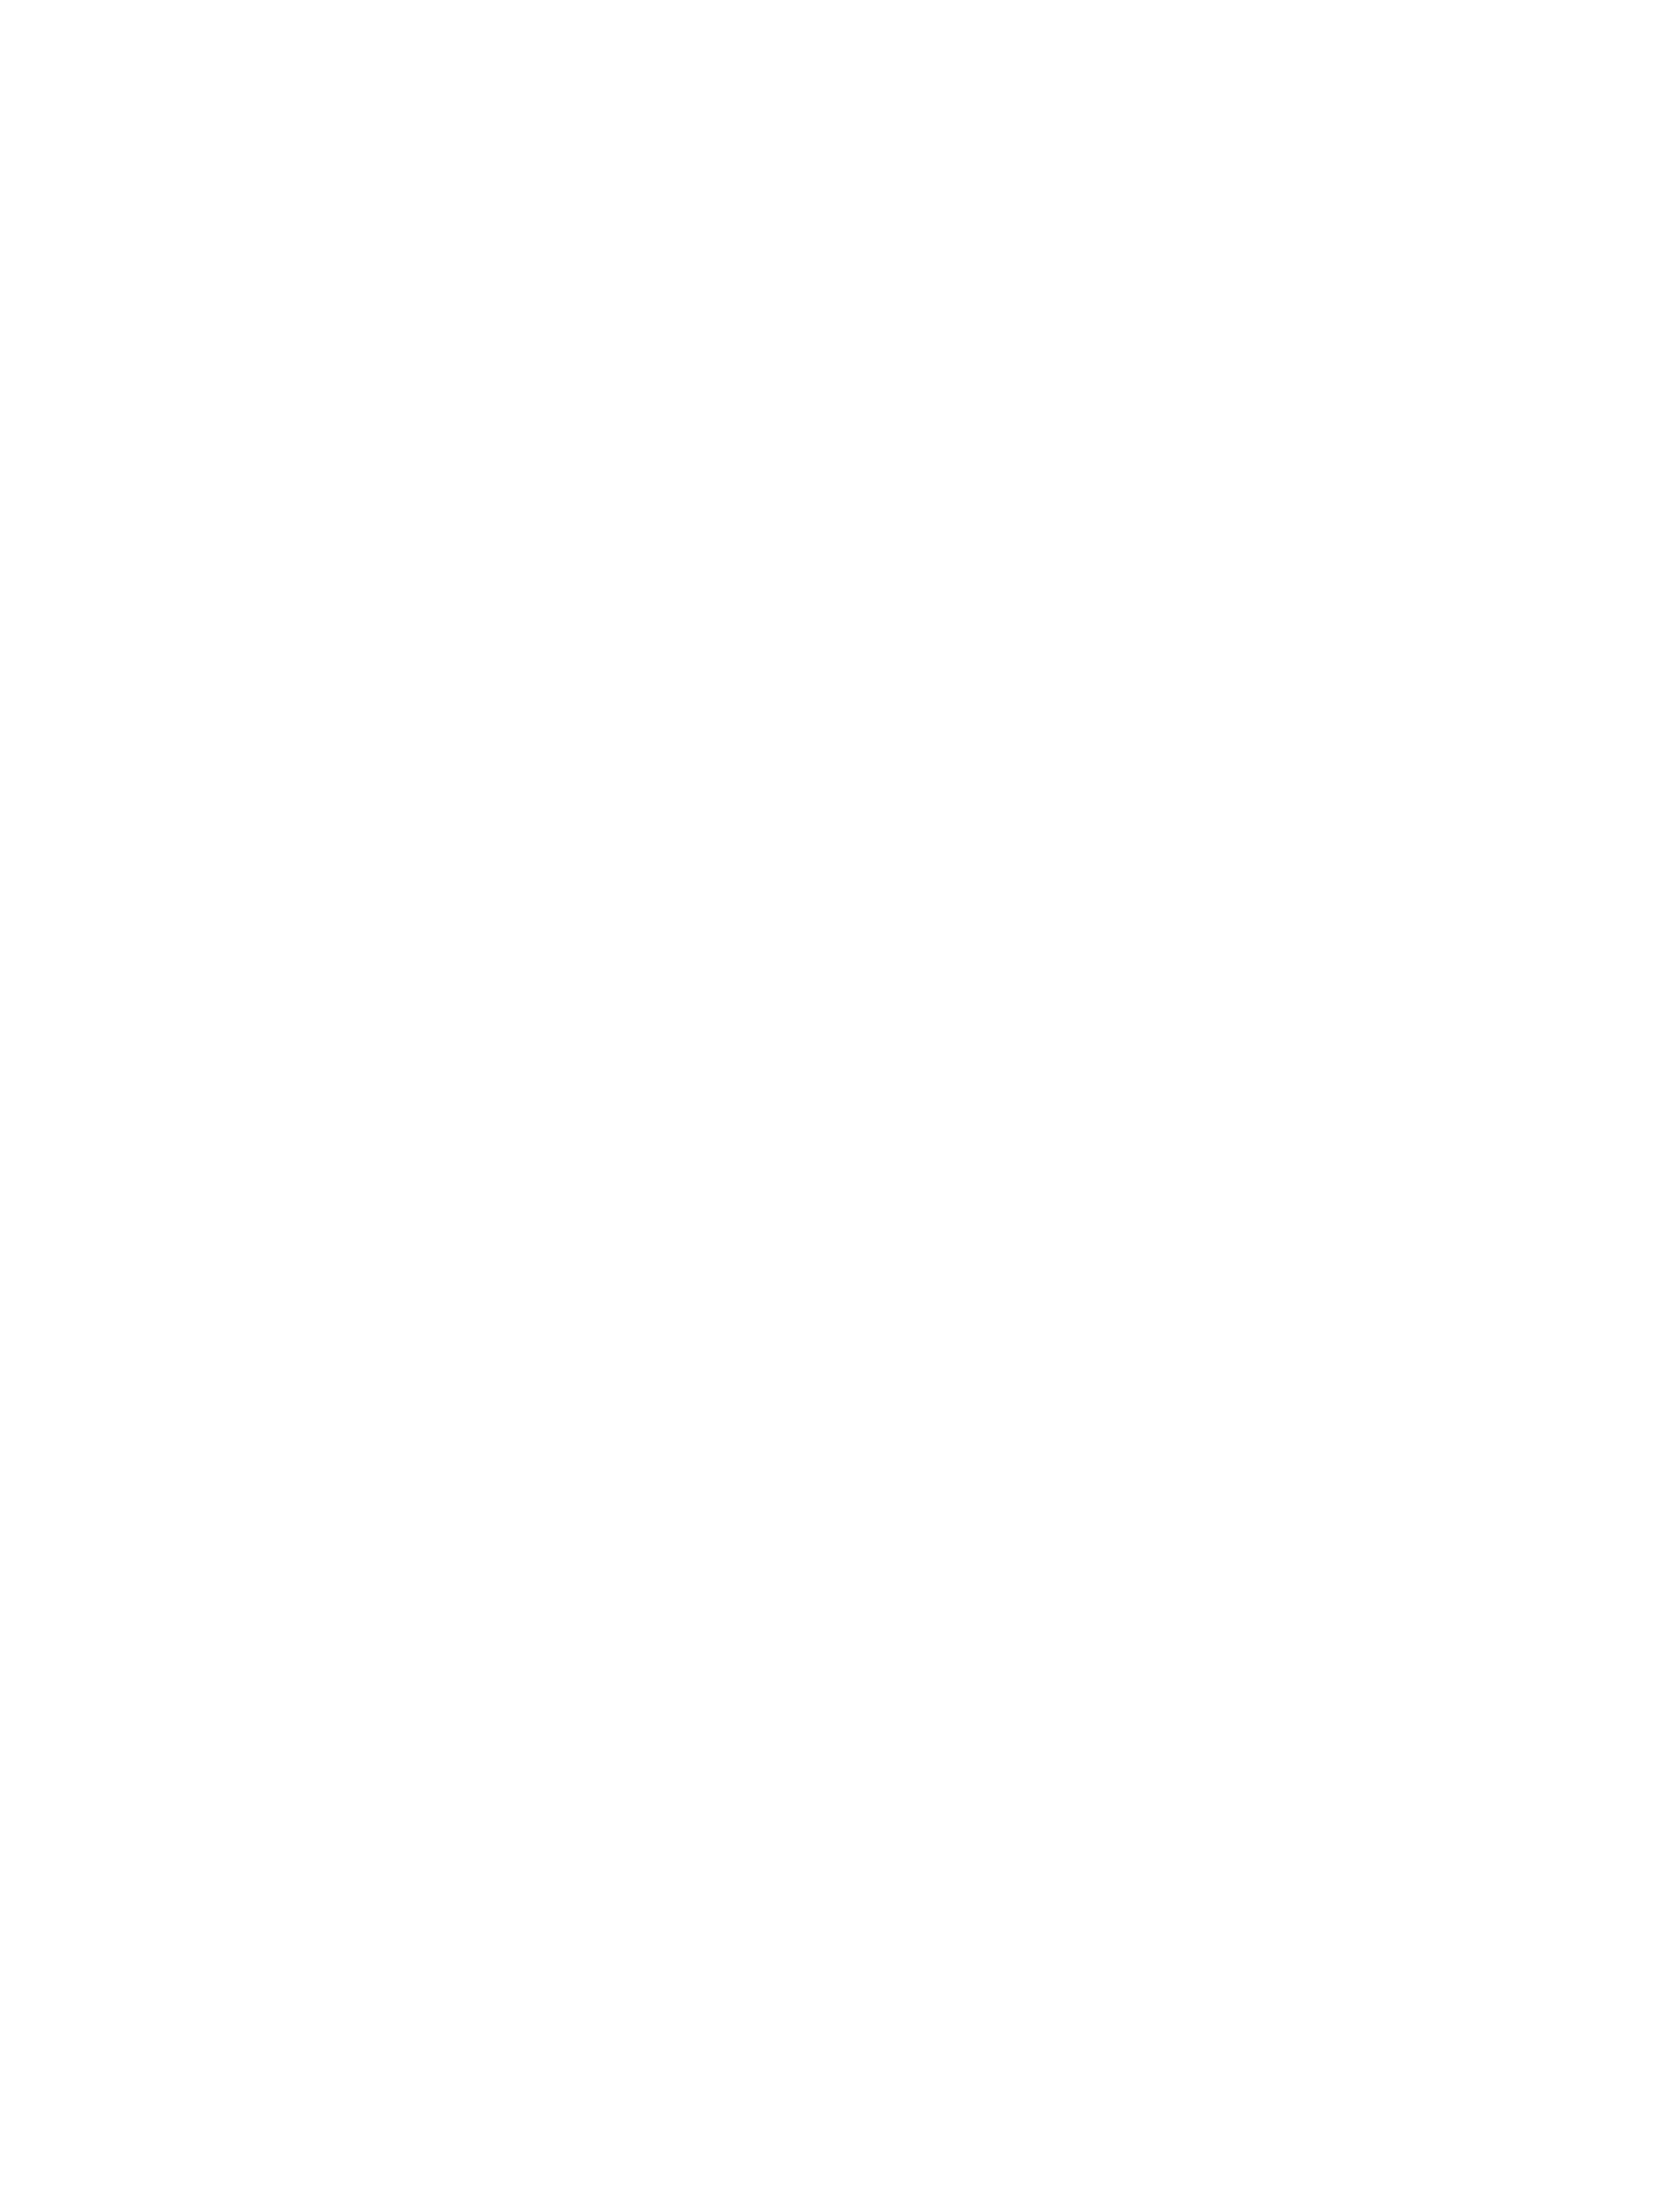

C:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0.0074197645


In [16]:
results={}
score_dict={}


mn=1
for b_sz in batch_sizes:
    for hl_scale in HL_scales:
        for lr in learning_rates:
            for opt in optimizers:
                opti=None
                if opt=='Adam': #This makes indexing easier later,
                    opti=Adam(learning_rate=lr)
                if opt=='SGD':
                    opti=SGD(learning_rate=lr)
                test_params=(b_sz,hl_scale,lr,opt)
                print("\n Model No. %d"%mn)
                print(test_params)
                layers=get_driver_layers(hl_scale,len(headers)-2,'relu')
                compile_params=[[],{'loss':'mean_squared_error', 'optimizer':opti, 'metrics':['mse']}]
                model=createNN(layer_params=layers,compile_params=compile_params)
                model.fit(Xtrn,ytrn,epochs=epochs,batch_size=b_sz)
                
                _,trn_score=model.evaluate(Xtrn,ytrn)

                _,test_score=model.evaluate(Xtst,ytst)

                pf_sum,avg_ctrl_iters,pf_by_world,ctrl_iters_by_world=simulate_model(model,[1],min_max_scaler,b_sz,True)

                results[test_params]={'layers':layers,'model':model,
                                      'training score':trn_score,'test score':test_score,
                                      'pf_score':pf_sum,'pf_by_world':pf_by_world,
                                      'avg_ctrl_iters':avg_ctrl_iters,'ctrl_iters_by_world':ctrl_iters_by_world}
                print(test_score)
                score_dict[test_params]=[trn_score,test_score,pf_sum,avg_ctrl_iters]
                mn+=1

## Results

In [17]:
results #Uncomment if you want to see a really long and not amazingly helpful variable string

{(64,
  4,
  0.001,
  'Adam'): {'layers': [[[64], {'input_dim': 34, 'activation': 'relu'}],
   [[256], {'activation': 'relu'}],
   [[256], {'activation': 'relu'}],
   [[1],
    {'activation': 'linear'}]], 'model': <keras.engine.sequential.Sequential at 0x1efc4f8c850>, 'training score': 0.0031907042, 'test score': 0.0074197645, 'pf_score': 0, 'pf_by_world': {1: 0}, 'avg_ctrl_iters': 2812.0, 'ctrl_iters_by_world': {1: 2812}}}

<IPython.core.display.Javascript object>


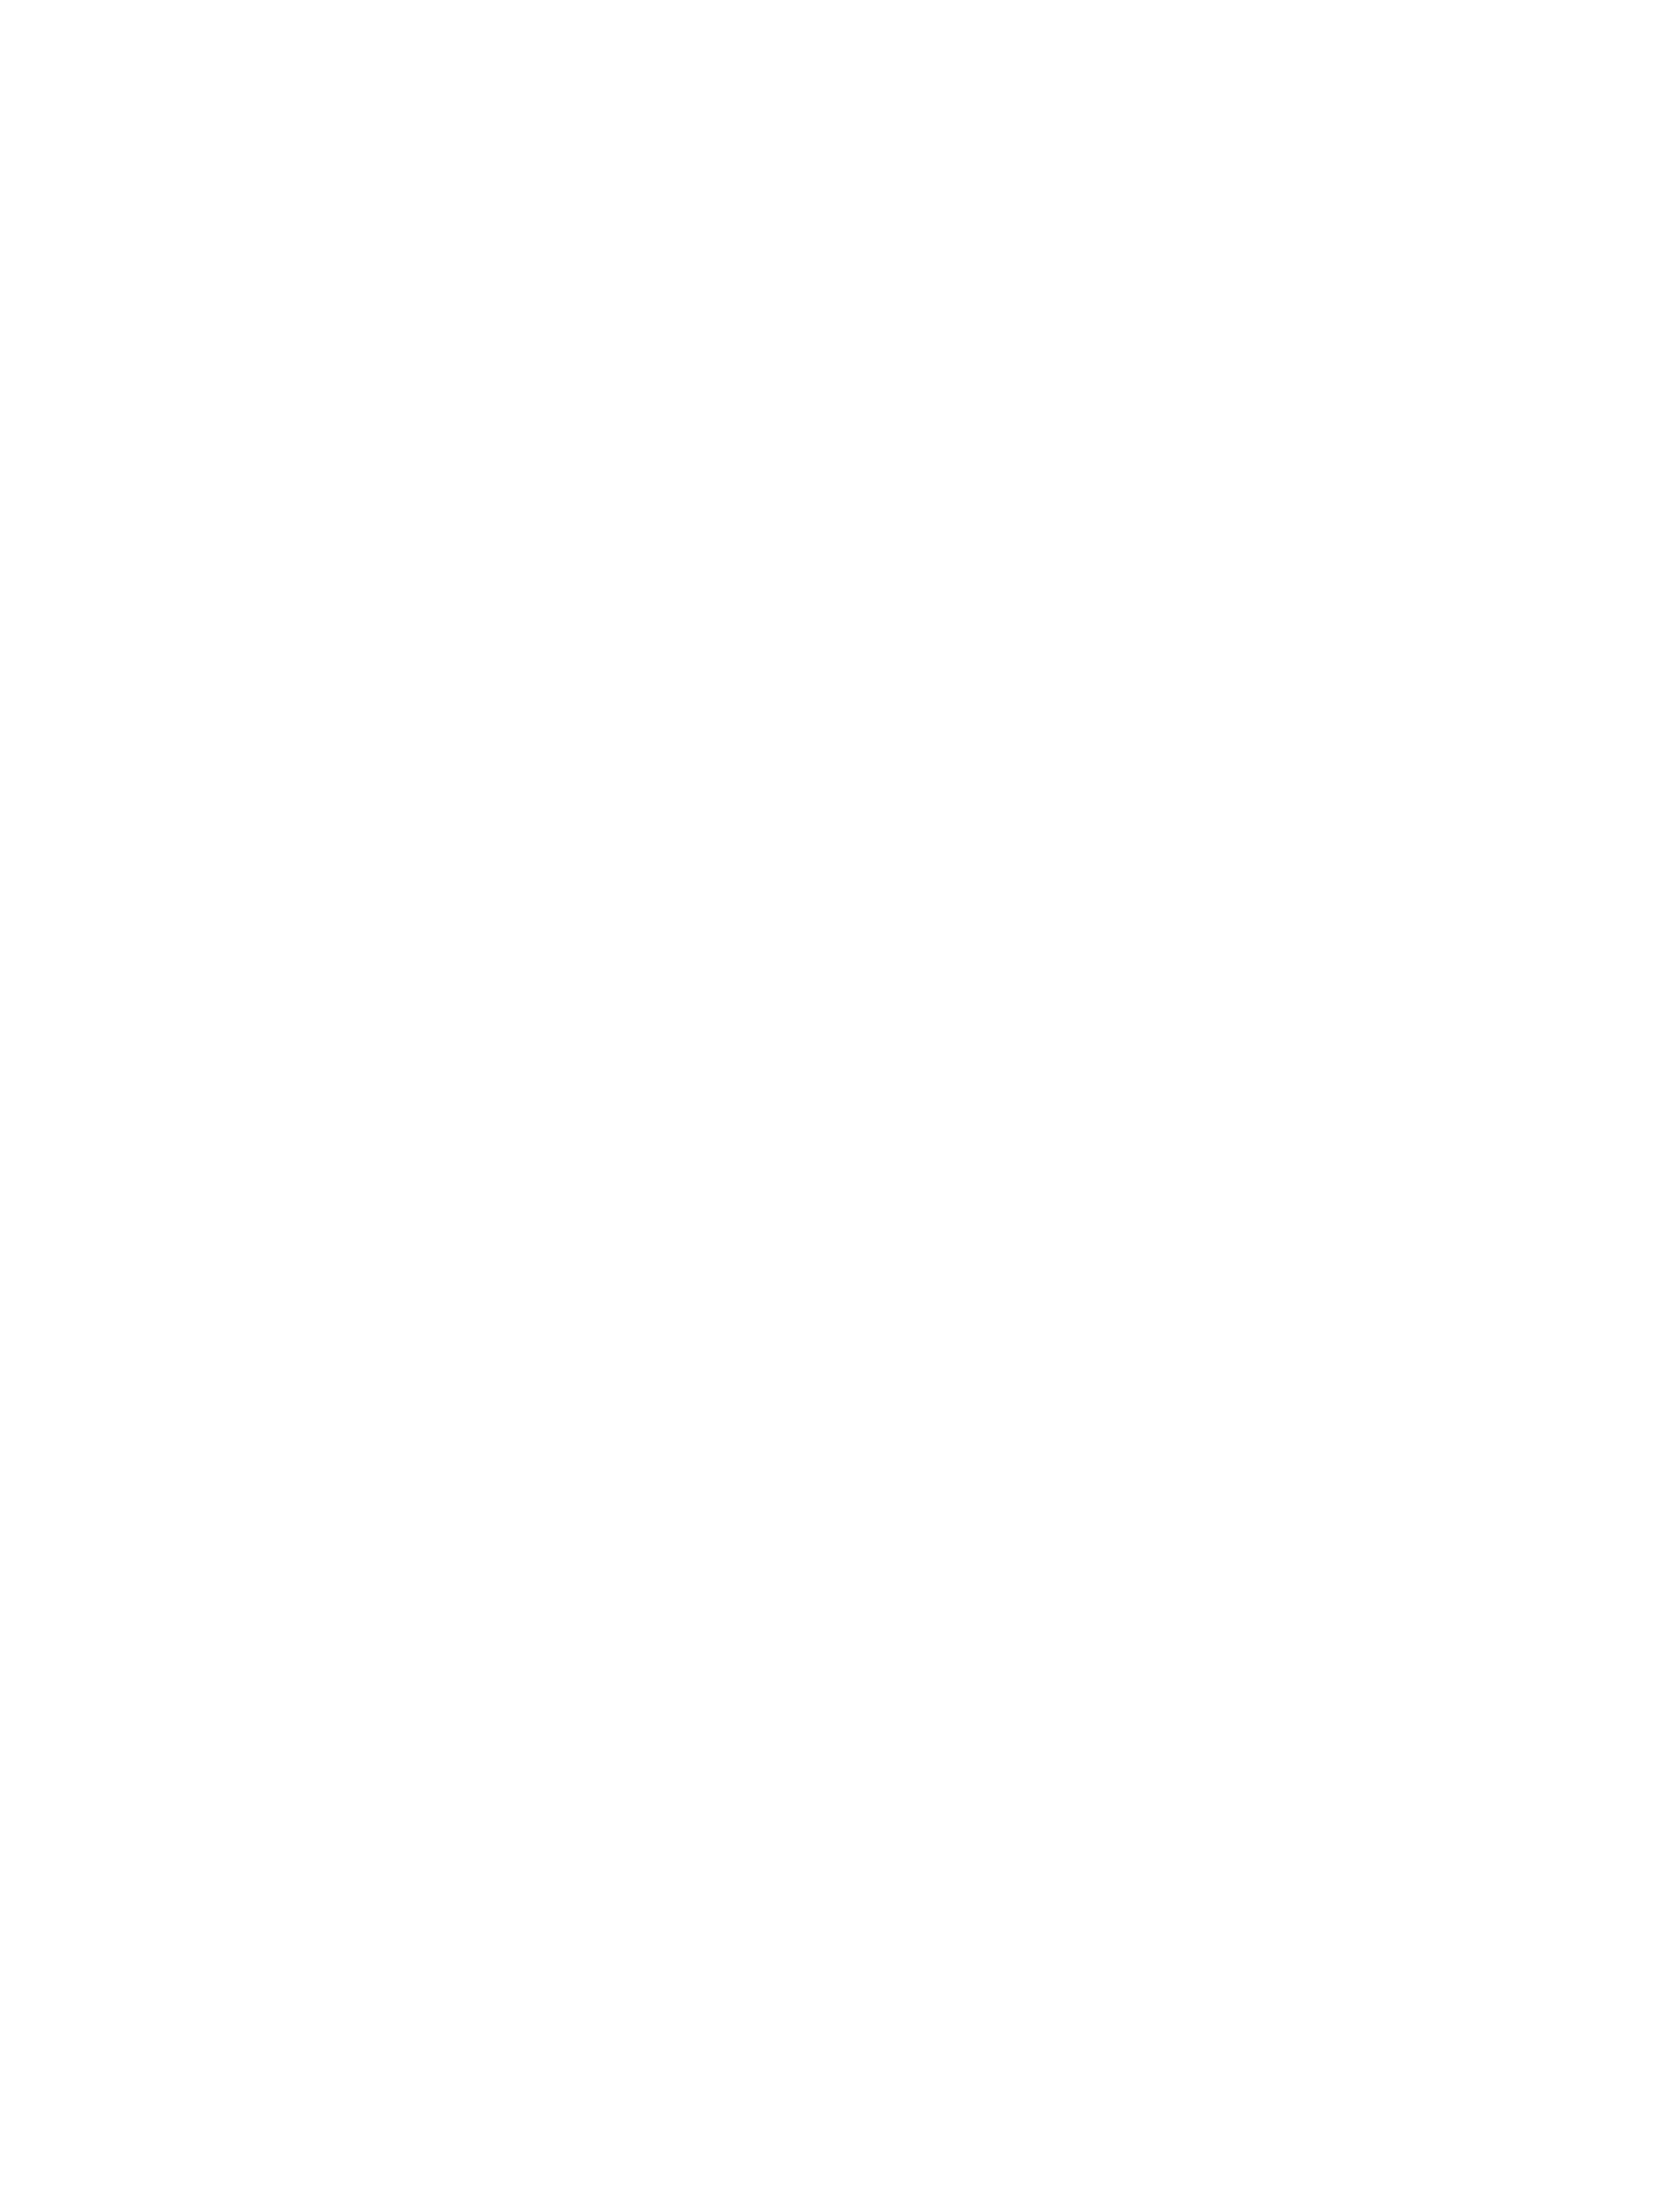

In [24]:
m=results[(64,
  4,
  0.001,
  'Adam')]['model']

pf_sum,avg_ctrl_iters,pf_by_world,ctrl_iters_by_world=simulate_model(m,[1],min_max_scaler,b_sz,True)

In [ ]:
idx=score_dict.keys()
vals=[score_dict[i] for i in idx]
idx
Score_df=pd.DataFrame(vals,index=idx,columns=['Training Score','Testing Score','NN Controller Pass Count','NN AVG Controller Iterations'])
Score_df.index.names=['Batch Size','HL_Scaler','Learning Rate','Optimizer']

In [ ]:
Score_df.head()

**Outputs**

In [ ]:
Score_df.to_csv('scores.csv')

# import pickle
# with open('result_dict.txt','wb') as fh:
#     pickle.dump(results,fh)

In [ ]:
Score_df